In [56]:

import lightgbm as lgb
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import data_get
import race_before_data
import pickle

from sklearn.metrics import recall_score

In [92]:
date = '2021-03-31'
data_get.download_file('racelists', date)
df_race = data_get.get_racelists(date)

df_race.to_csv(f"dataset/rawdata_syussouhyou/{date}_race_list.csv", encoding='utf_8_sig')

In [93]:
date = '2021-03-31'
place_cd = 18
race_no = 2
bi = race_before_data.get_beforeinfo(date, place_cd, race_no)

[['6.94', '-0.5'], ['7.05', '-0.5'], ['6.99', '-0.5'], ['7.00', '-0.5'], ['6.94', '-0.5'], ['6.93', '-0.5']]
[['-.03' 1]
 ['.05' 4]
 ['.03' 2]
 ['.07' 3]
 ['.13' 6]
 ['-.04' 5]]


In [94]:
race_info_df = df_race[(df_race['place_cd'] == place_cd) & (df_race['race_no'] == race_no)]

In [95]:
tmp = pd.merge(race_info_df, pd.DataFrame(bi).T, on=["race_no", "place_cd"])

In [96]:
race_info_df

,title,day,date,place_cd,place,race_no,race_type,distance,deadline,toban_1,...,boat_no_3,boat_no_4,boat_no_5,boat_no_6,boat_in2_1,boat_in2_2,boat_in2_3,boat_in2_4,boat_in2_5,boat_in2_6
37,サンケイスポーツ杯争奪戦,6,2021-03-31,18,徳山,2,モーニング一,1800,09:19,4222,...,28,50,11,38,34.48,37.63,42.86,41.25,30.11,36.67


In [97]:
pd.DataFrame(bi).T

,date,place_cd,race_no,ET_1,ET_2,ET_3,ET_4,ET_5,ET_6,tilt_1,...,ESC_3,ESC_4,ESC_5,ESC_6,wether,air_t,wind_d,wind_v,water_t,wave_h
0,2021-03-31,18,2,6.94,7.05,6.99,7.0,6.94,6.93,-0.5,...,2,3,6,5,晴,12.0,9,1.0,13.0,1.0


In [98]:
tmp

,title,day,date_x,place_cd,place,race_no,race_type,distance,deadline,toban_1,...,ESC_3,ESC_4,ESC_5,ESC_6,wether,air_t,wind_d,wind_v,water_t,wave_h
0,サンケイスポーツ杯争奪戦,6,2021-03-31,18,徳山,2,モーニング一,1800,09:19,4222,...,2,3,6,5,晴,12.0,9,1.0,13.0,1.0


In [99]:
usecols = [f'{k}_{i}' for k in ('class', 'glob_win', 'glob_in2',
                                'loc_win', 'loc_in2', 'moter_in2', 'boat_in2', 'EST','ESC' )
            for i in range(1, 7)]
usecols += [f'ET_{i}'
            for i in range(1, 7)]

tmp = tmp[usecols]

def rank_mapper(x):
    if 'A1' in x:
        y = 4
    elif 'A2' in x:
        y = 3
    elif 'B1' in x:
        y = 2
    else:
        y = 1
    return y

for i in range(1,7):
    col_name_class = f"class_{i}"
    tmp[col_name_class] = tmp[col_name_class].map(rank_mapper)
class_col = [s for s in tmp.columns if "class" in s]

/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/2188747993.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[col_name_class] = tmp[col_name_class].map(rank_mapper)


In [100]:
def hensachi(x):
    print(f"x:{x}")
    x = x.astype(float)
    if x.std() == 0:
        return np.full(6,50.0)

    hensa = (x - x.mean())*10/x.std()+50

    return hensa
tmp.loc[:, class_col] = tmp.loc[:,class_col].apply(hensachi,axis=1)

hensa_col = ['glob_win', 'glob_in2','loc_win', 'loc_in2', 'moter_in2', 'boat_in2', 'EST', "ET","ESC"]

for i in hensa_col:
    class_col = [s for s in tmp.columns if i in s]
    print(class_col)
    tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)

/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, class_col] = tmp.loc[:,class_col].apply(hensachi,axis=1)


x:class_1    3
class_2    3
class_3    2
class_4    3
class_5    1
class_6    3
Name: 0, dtype: int64
['glob_win_1', 'glob_win_2', 'glob_win_3', 'glob_win_4', 'glob_win_5', 'glob_win_6']
x:glob_win_1    5.06
glob_win_2    4.51
glob_win_3    5.53
glob_win_4    6.36
glob_win_5    1.80
glob_win_6    5.19
Name: 0, dtype: object
['glob_in2_1', 'glob_in2_2', 'glob_in2_3', 'glob_in2_4', 'glob_in2_5', 'glob_in2_6']
x:glob_in2_1    36.89
glob_in2_2    25.23
glob_in2_3    33.98
glob_in2_4    42.74
glob_in2_5     3.92
glob_in2_6    34.17
Name: 0, dtype: object


/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)
/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)


['loc_win_1', 'loc_win_2', 'loc_win_3', 'loc_win_4', 'loc_win_5', 'loc_win_6']
x:loc_win_1    4.88
loc_win_2    5.24
loc_win_3    5.52
loc_win_4    6.41
loc_win_5    1.43
loc_win_6    4.94
Name: 0, dtype: object
['loc_in2_1', 'loc_in2_2', 'loc_in2_3', 'loc_in2_4', 'loc_in2_5', 'loc_in2_6']
x:loc_in2_1    33.33
loc_in2_2    34.21
loc_in2_3    35.42
loc_in2_4    53.66
loc_in2_5     0.00
loc_in2_6    27.66
Name: 0, dtype: object


/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)
/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)


['moter_in2_1', 'moter_in2_2', 'moter_in2_3', 'moter_in2_4', 'moter_in2_5', 'moter_in2_6']
x:moter_in2_1    23.94
moter_in2_2    29.02
moter_in2_3    30.45
moter_in2_4    37.89
moter_in2_5    35.87
moter_in2_6    26.50
Name: 0, dtype: object
['boat_in2_1', 'boat_in2_2', 'boat_in2_3', 'boat_in2_4', 'boat_in2_5', 'boat_in2_6']
x:boat_in2_1    34.48
boat_in2_2    37.63
boat_in2_3    42.86
boat_in2_4    41.25
boat_in2_5    30.11
boat_in2_6    36.67
Name: 0, dtype: object


/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)
/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)


['EST_1', 'EST_2', 'EST_3', 'EST_4', 'EST_5', 'EST_6']
x:EST_1   -0.03
EST_2    0.05
EST_3    0.03
EST_4    0.07
EST_5    0.13
EST_6   -0.04
Name: 0, dtype: object
['ET_1', 'ET_2', 'ET_3', 'ET_4', 'ET_5', 'ET_6']
x:ET_1    6.94
ET_2    7.05
ET_3    6.99
ET_4     7.0
ET_5    6.94
ET_6    6.93
Name: 0, dtype: object


/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)
/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)


['ESC_1', 'ESC_2', 'ESC_3', 'ESC_4', 'ESC_5', 'ESC_6']
x:ESC_1    1
ESC_2    4
ESC_3    2
ESC_4    3
ESC_5    6
ESC_6    5
Name: 0, dtype: object


/var/folders/s6/7jf_zlp94gg5cpb8c5lrx2j80000gn/T/ipykernel_35204/1263610910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[class_col] = tmp.loc[:, class_col].apply(hensachi,axis=1)


In [101]:
X = tmp.values

In [102]:
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
# テストデータの予測クラス (予測クラス(0 or 1 or 2)を返す)
y_pred = model.predict(X)
# テストデータのクラス予測確率 (各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す)
y_pred_prob = model.predict_proba(X)

In [103]:
y_pred_prob

array([[0.32635867, 0.07819522, 0.09488832, 0.13498815, 0.00666444,
        0.35890519]])

In [104]:
y_pred

array([6])

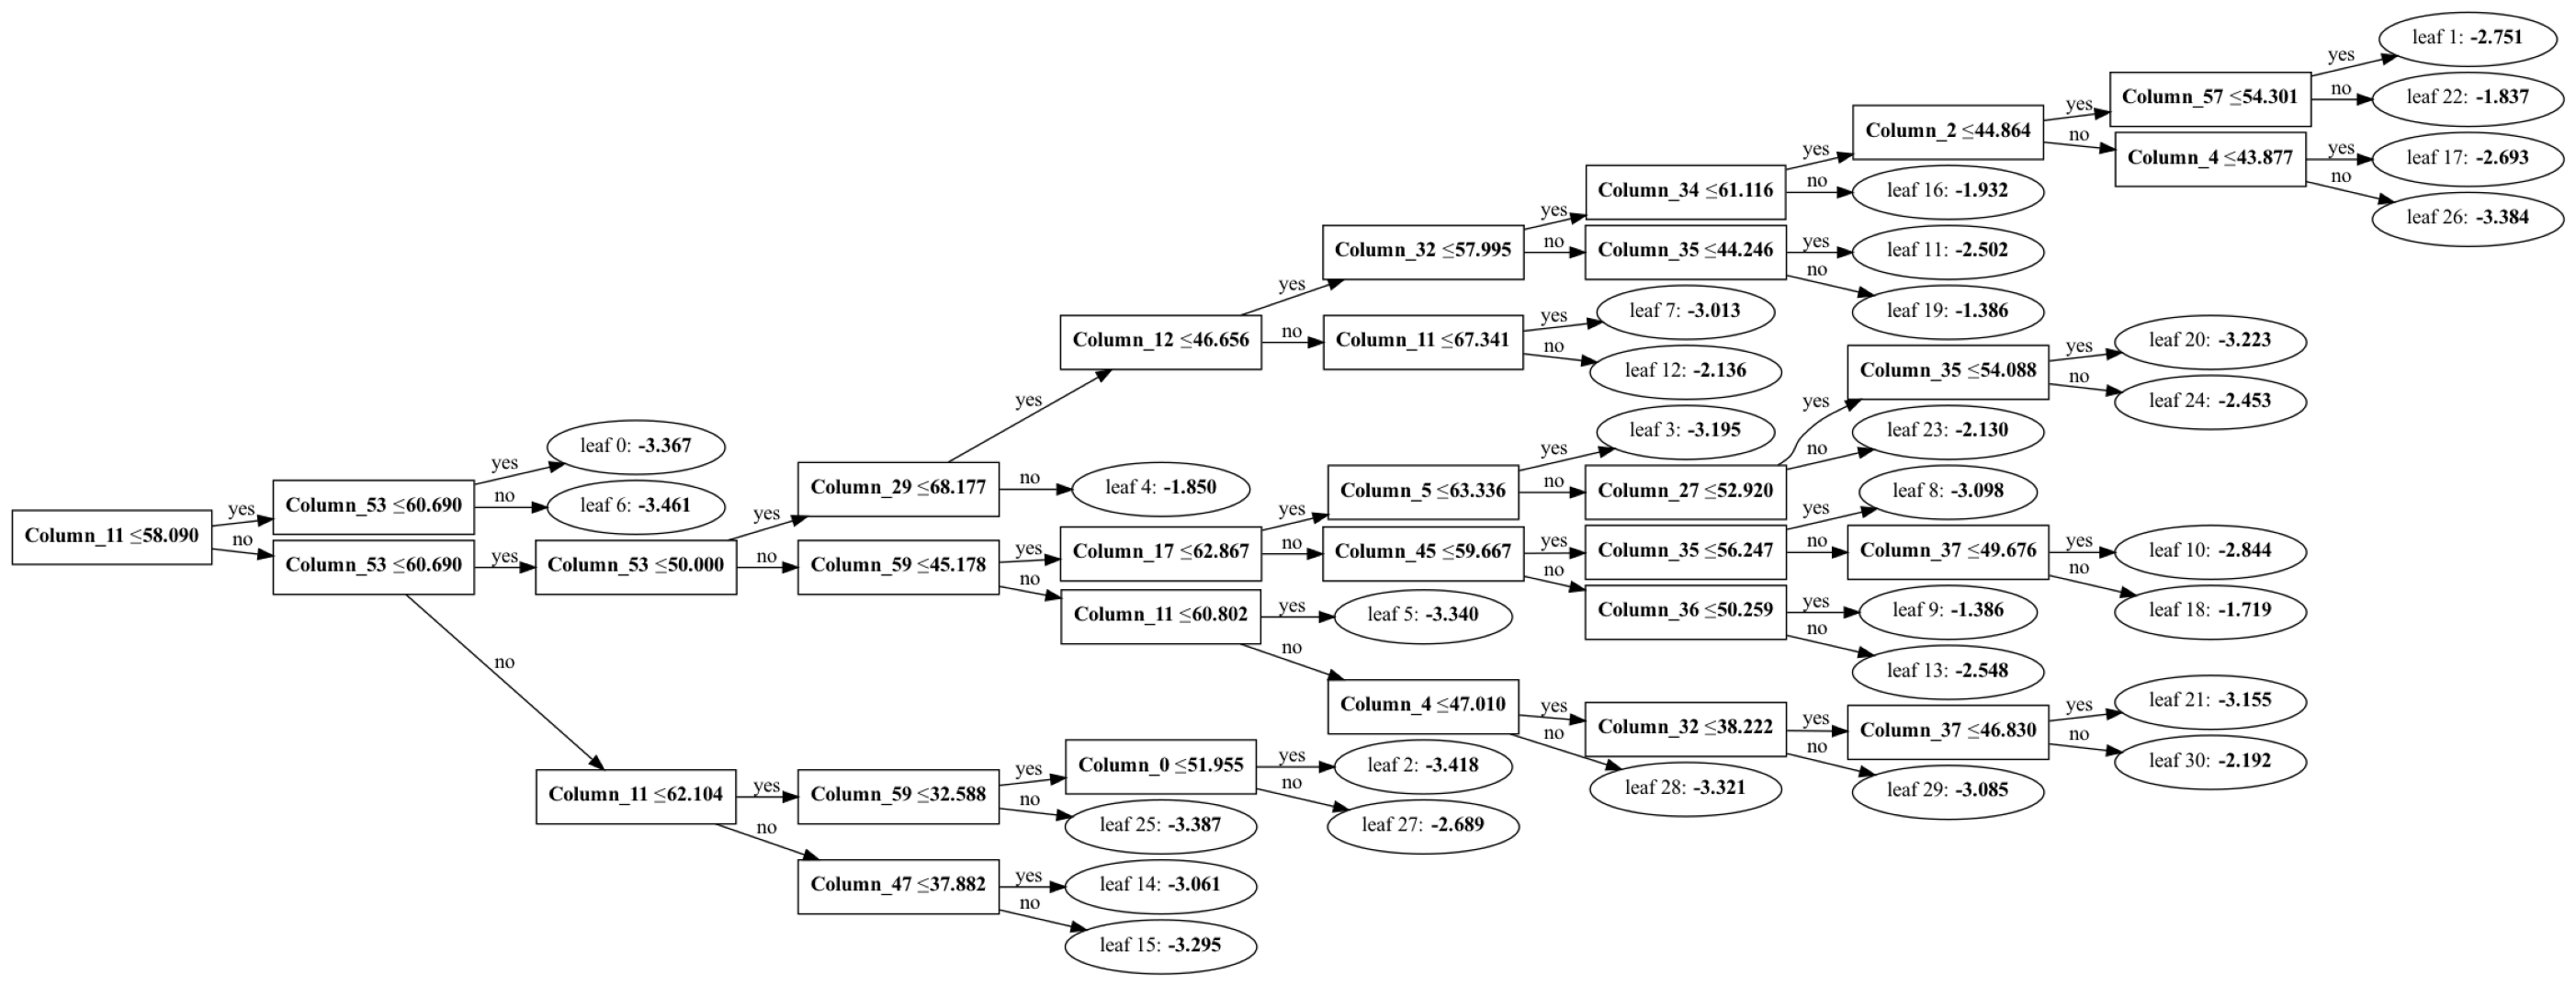

In [105]:
fig, ax = plt.subplots(figsize=(50, 50))
lgb.plot_tree(model, tree_index=5,ax=ax)
plt.show()

In [106]:
model.booster_.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S2,None,Column_6,2080.040039,53.303416,<=,left,None,-0.602086,0.000000,35810
1,0,2,0-S1,0-S3,0-S5,0-S0,Column_0,325.532990,48.721029,<=,left,None,-0.648060,5113.690000,17202
2,0,3,0-S3,0-S7,0-S8,0-S1,Column_12,122.845001,45.917875,<=,left,None,-0.666953,3276.550000,11022
3,0,4,0-S7,0-S11,0-S17,0-S3,Column_54,30.990299,44.963898,<=,left,None,-0.683106,1931.980000,6499
4,0,5,0-S11,0-L0,0-L12,0-S7,Column_24,23.107599,47.508186,<=,left,None,-0.667666,777.072000,2614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36595,599,10,599-L25,None,None,599-S26,None,NaN,NaN,None,None,None,-0.085166,1.944488,174
36596,599,10,599-L27,None,None,599-S26,None,NaN,NaN,None,None,None,0.111056,4.936019,232
36597,599,9,599-L26,None,None,599-S25,None,NaN,NaN,None,None,None,-0.042986,15.496535,1195
36598,599,6,599-L23,None,None,599-S22,None,NaN,NaN,None,None,None,0.026089,79.063676,843


In [107]:

tmp

,class_1,class_2,class_3,class_4,class_5,class_6,glob_win_1,glob_win_2,glob_win_3,glob_win_4,...,ESC_3,ESC_4,ESC_5,ESC_6,ET_1,ET_2,ET_3,ET_4,ET_5,ET_6
0,55.976143,55.976143,44.023857,55.976143,32.071571,55.976143,52.033767,48.519929,55.036501,60.339202,...,41.982163,47.327388,63.363062,58.017837,42.520958,66.026519,53.205304,55.342173,42.520958,40.384089


In [108]:

df_race.sort_values(by="deadline")

,title,day,date,place_cd,place,race_no,race_type,distance,deadline,toban_1,...,boat_no_3,boat_no_4,boat_no_5,boat_no_6,boat_in2_1,boat_in2_2,boat_in2_3,boat_in2_4,boat_in2_5,boat_in2_6
12,山口シネマ杯近況絶好調軍団,5,2021-03-31,21,芦屋,1,一般,1800,08:47,4580,...,36,56,31,51,37.50,31.28,32.06,36.15,39.82,32.86
36,サンケイスポーツ杯争奪戦,6,2021-03-31,18,徳山,1,モーニング一,1800,08:50,3663,...,52,25,31,64,34.15,32.95,40.45,29.21,38.55,36.26
13,山口シネマ杯近況絶好調軍団,5,2021-03-31,21,芦屋,2,一般,1800,09:16,3527,...,67,46,27,12,40.09,34.63,29.17,34.91,46.03,32.02
37,サンケイスポーツ杯争奪戦,6,2021-03-31,18,徳山,2,モーニング一,1800,09:19,4222,...,28,50,11,38,34.48,37.63,42.86,41.25,30.11,36.67
14,山口シネマ杯近況絶好調軍団,5,2021-03-31,21,芦屋,3,一般,1800,09:45,3462,...,30,65,64,37,28.13,38.14,36.61,36.10,34.62,32.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,かっぱくん杯,3,2021-03-31,20,若松,11,一般特選,1800,20:16,4063,...,46,45,33,67,36.48,30.07,37.06,33.94,36.08,33.76
11,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,12,予選特選,1800,20:33,4537,...,15,51,26,66,28.99,31.67,40.33,32.97,37.79,35.88
35,かっぱくん杯,3,2021-03-31,20,若松,12,一般特選,1800,20:41,4566,...,23,38,47,36,38.41,38.27,38.69,29.14,30.77,40.14
107,日本モーターボート選手会会長杯争奪戦,5,2021-03-31,7,蒲郡,12,優勝戦,1800,20:43,4561,...,56,74,48,54,28.96,40.98,28.49,30.10,44.95,27.95


In [109]:

date = '2021-03-31'
data_get.download_file('results', date)
df_result = data_get.get_results(date)

In [110]:
df_result

,title,day,date,place_cd,place,race_no,race_type,distance,toban_1,toban_2,...,odds_3f,poprank_2t,poprank_2f,poprank_w1,poprank_w2,poprank_w3,poprank_3t,poprank_3f,win_method,wakunari
0,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,1,予選,1800,3444,5029,...,4.5,3,1,2,8,6,5,2,差し,1
1,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,2,予選,1800,3741,4593,...,2.2,2,1,4,2,3,1,1,逃げ,1
2,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,3,予選,1800,4005,4247,...,7.6,4,4,3,1,9,17,5,逃げ,0
3,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,4,予選,1800,3819,3300,...,17.2,8,3,5,8,10,28,6,まくり差し,0
4,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,5,予選,1800,4348,4295,...,14.0,5,5,4,5,8,20,6,差し,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,サンスポZBAT!杯,2,2021-03-31,2,戸田,8,予選,1800,4610,4988,...,21.7,8,3,4,11,9,42,8,差し,0
140,サンスポZBAT!杯,2,2021-03-31,2,戸田,9,戸田特賞,1800,4748,3251,...,5.2,5,2,2,5,3,5,2,まくり,1
141,サンスポZBAT!杯,2,2021-03-31,2,戸田,10,戸田特賞,1800,3966,3984,...,19.6,2,2,4,9,10,11,8,逃げ,1
142,サンスポZBAT!杯,2,2021-03-31,2,戸田,11,戸田特選,1800,3898,4645,...,2.8,2,1,1,4,2,4,1,まくり,1


In [111]:
df_race

,title,day,date,place_cd,place,race_no,race_type,distance,deadline,toban_1,...,boat_no_3,boat_no_4,boat_no_5,boat_no_6,boat_in2_1,boat_in2_2,boat_in2_3,boat_in2_4,boat_in2_5,boat_in2_6
0,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,1,予選,1800,15:15,3444,...,34,56,28,16,21.05,27.81,27.78,30.95,35.12,30.29
1,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,2,予選,1800,15:38,3741,...,12,66,33,17,30.29,35.96,25.79,35.88,38.33,39.20
2,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,3,予選,1800,16:06,4005,...,53,13,50,27,39.44,29.82,34.64,31.67,27.84,33.90
3,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,4,予選,1800,16:37,3819,...,72,69,75,52,34.64,29.45,32.54,27.22,36.57,29.89
4,おおむら桜祭り競走マンスリーBOATRACE杯,3,2021-03-31,24,大村,5,予選,1800,17:02,4348,...,26,73,19,40,30.86,26.97,37.79,33.70,37.85,32.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,サンスポZBAT!杯,2,2021-03-31,2,戸田,8,予選,1800,14:16,4610,...,72,47,35,14,31.45,46.21,34.18,28.85,40.28,34.33
140,サンスポZBAT!杯,2,2021-03-31,2,戸田,9,戸田特賞,1800,14:48,4748,...,45,25,18,59,28.68,30.72,22.29,42.96,27.78,40.51
141,サンスポZBAT!杯,2,2021-03-31,2,戸田,10,戸田特賞,1800,15:21,3966,...,29,53,73,75,41.18,42.66,31.82,33.81,42.86,30.61
142,サンスポZBAT!杯,2,2021-03-31,2,戸田,11,戸田特選,1800,15:55,3898,...,27,63,68,38,28.48,27.27,34.21,30.82,32.47,28.66
